<a href="https://colab.research.google.com/github/outfox330/ML_Models_on_Time_Series/blob/main/Volatility_Forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install plotly
! pip install xgboost
! pip install arch
# statsmodels, sklearn,
! pip install yfinance

import math
import datetime
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
import yfinance as yf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 10.4 MB/s eta 0:00:00


In [5]:
df = yf.download('^GSPC', '2004-01-03')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-05,1108.479980,1122.219971,1108.479980,1122.219971,1122.219971,1578200000
2004-01-06,1122.219971,1124.459961,1118.439941,1123.670044,1123.670044,1494500000
2004-01-07,1123.670044,1126.329956,1116.449951,1126.329956,1126.329956,1704900000
2004-01-08,1126.329956,1131.920044,1124.910034,1131.920044,1131.920044,1868400000
2004-01-09,1131.920044,1131.920044,1120.900024,1121.859985,1121.859985,1720700000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5219 entries, 2004-01-05 to 2024-09-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5219 non-null   float64
 1   High       5219 non-null   float64
 2   Low        5219 non-null   float64
 3   Close      5219 non-null   float64
 4   Adj Close  5219 non-null   float64
 5   Volume     5219 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 285.4 KB


In [7]:
df.shape

(5219, 6)

In [17]:
stock_raw_data = df.copy()
returns = stock_raw_data.Close.pct_change()*100
returns = returns.dropna()
returns = returns.drop(returns[returns == 0].index)
returns.head()

,Close
Date,
2004-01-06,0.129215
2004-01-07,0.236716
2004-01-08,0.496310
2004-01-09,-0.888761
2004-01-12,0.478669


<Axes: title={'center': '^GSPC Daily Returns'}, xlabel='Date'>

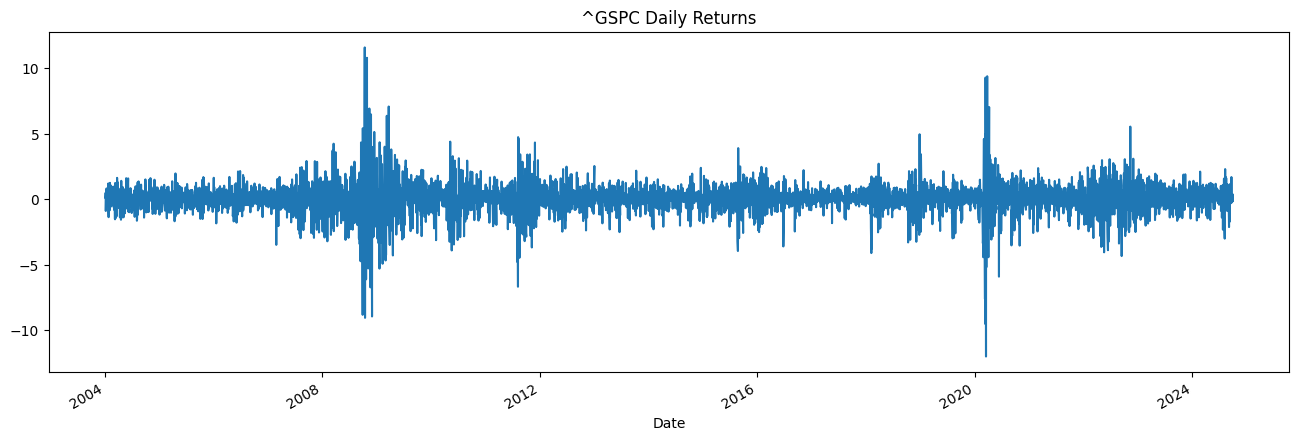

In [18]:
returns.plot(figsize =(16,5), title = '^GSPC Daily Returns')

In [19]:
close_prices = pd.DataFrame(stock_raw_data["Close"])
cum_rets = close_prices / close_prices.iloc[0,:]

fig = px.line(cum_rets.iloc[:,:], width=1000, height=500)

fig.update_layout(title_text='Cumulative Return of ^GSPC')

fig.show()

In [20]:
daily_volatility = returns.std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility
print(tabulate([['^GSPC',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ ^GSPC │         1.19         │          5.47          │         18.93         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


In [21]:
return_dist_plot  = ff.create_distplot([returns.values.reshape(-1)], group_labels = [' '])
return_dist_plot.update_layout(showlegend=False, title_text='Distribution of ^GSPC Daily Returns', width=1000, height=500)
return_dist_plot.show()

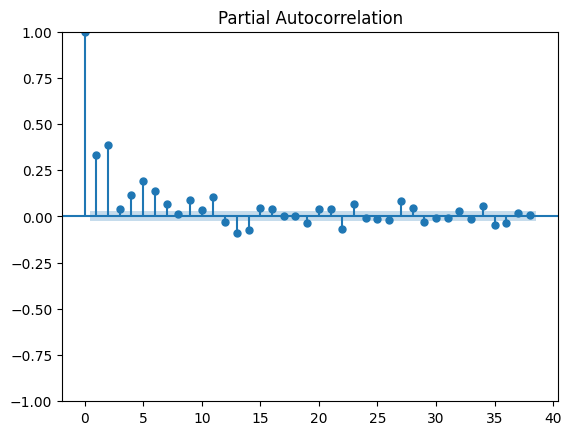

In [22]:
plot_pacf(returns**2,method="yw")
plt.show()

In [23]:
model = arch_model(returns,dist="ged", vol = 'GARCH', p=2, q=2)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                              Close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -6733.55
Distribution:      Generalized Error Distribution   AIC:                           13481.1
Method:                        Maximum Likelihood   BIC:                           13527.0
                                                    No. Observations:                 5216
Date:                            Sun, Sep 29 2024   Df Residuals:                     5215
Time:                                    15:31:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0796  9.110e-03      8.740  2.336e-18 [6.176e-02,9.747e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0309  1.184e-02      2.614  8.951e-03 [7.743e-03,5.415e-02]
alpha[1]       0.0789  2.098e-02      3.761  1.691e-04   [3.779e-02,  0.120]
alpha[2]       0.1045  6.502e-02      1.608      0.108  [-2.291e-02,  0.232]
beta[1]        0.5902      0.570      1.035      0.300     [ -0.527,  1.707]
beta[2]        0.2045      0.495      0.413      0.680     [ -0.766,  1.175]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.2892  3.937e-02     32.741 4.067e-235 [  1.212,  1.366]
========================================================================

Covariance estimator: robust
"""

In [24]:
full_series_garch = arch_model(returns,dist="ged", vol = 'GARCH', p=2, q=2)
model_fit_full_series = full_series_garch.fit(disp='off')

In [25]:
model_fit_full_series.conditional_volatility

,cond_vol
Date,
2004-01-06,0.663044
2004-01-07,0.647859
2004-01-08,0.608905
2004-01-09,0.593192
2004-01-12,0.637635
...,...
2024-09-23,0.948395
2024-09-24,0.855334
2024-09-25,0.808215


In [26]:
rolling_vol = abs(returns.rolling(window=22, min_periods=22).std().dropna())

In [27]:
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_series.conditional_volatility),rolling_vol.dropna()], axis=1).dropna()
garch_and_rolling_std_plot = px.line(garch_and_rolling_std, title = 'GARCH vs Rolling Volatility of Daily Returns', width=1000, height=500)
garch_and_rolling_std_plot.show()

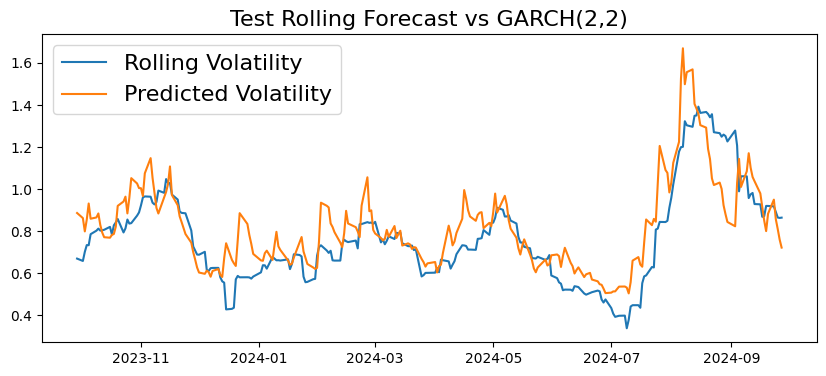

In [29]:
test_size = 251
rolling_predictions = []

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train,dist="ged", vol = 'GARCH', p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index= returns.dropna().index[-test_size:])
plt.figure(figsize=(10,4))
true, = plt.plot((rolling_vol)[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Test Rolling Forecast vs GARCH(2,2)', fontsize=16)
plt.legend(['Rolling Volatility', 'Predicted Volatility'], fontsize=16)

In [37]:
stock_raw_data_for_ml = df.copy()
stock_raw_data_for_ml['Date']=stock_raw_data_for_ml.index
returns_for_ml =stock_raw_data_for_ml[["Date","Close"]]
returns_for_ml["Close"] = 100 * stock_raw_data.Close.pct_change().dropna()
returns_for_ml  = returns_for_ml.drop(returns_for_ml[returns_for_ml["Close"] == 0].index)
returns_for_ml = returns_for_ml.dropna()
returns_for_ml["Close"] = abs(returns_for_ml["Close"].rolling(window=22, min_periods=22).std().dropna())
returns_for_ml["Date"] = pd.to_datetime(returns_for_ml["Date"])
returns_for_ml.tail()

,Date,Close
Date,,
2024-09-23,2024-09-23,0.917279
2024-09-24,2024-09-24,0.891397
2024-09-25,2024-09-25,0.864103
2024-09-26,2024-09-26,0.862283
2024-09-27,2024-09-27,0.863586


In [40]:
series_for_xgboost = returns_for_ml
#Set the test size
test_size = 251
#Split train and test
train_ml = series_for_xgboost[:-(test_size)].dropna()
test_ml = series_for_xgboost[-(test_size):].dropna()

In [41]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day


    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(train_ml, label="Close")
X_test, y_test = create_features(test_ml, label="Close")

In [42]:
X_train['prev1']=train_ml['Close'].shift(1)
X_test['prev1']=test_ml['Close'].shift(1)
X_train['prev2'] =train_ml['Close'].shift(2)
X_test['prev2']=test_ml['Close'].shift(2)
X_train['prev3'] =train_ml['Close'].shift(3)
X_test['prev3']=test_ml['Close'].shift(3)
X_train['prev4'] =train_ml['Close'].shift(4)
X_test['prev4']=test_ml['Close'].shift(4)

In [43]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

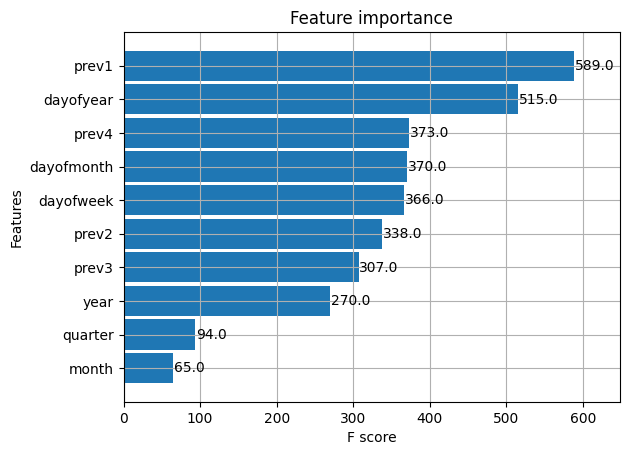

In [44]:
_ = plot_importance(reg, height=0.9)

In [45]:
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [46]:
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Close"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Volatility",0:"Predicted Volatility"}, inplace=True)

XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["Close"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Volatility",0:"Predicted Volatility"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs Rolling Volatility of Daily Returns', width=1000, height=500)
XGBoost_and_rolling.show()

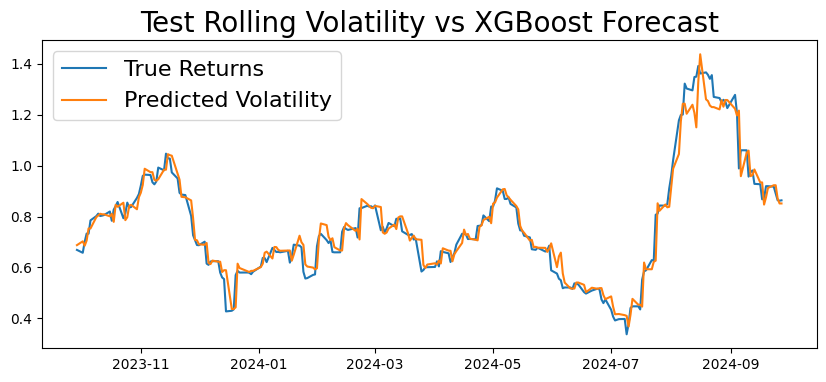

In [47]:
plt.figure(figsize=(10,4))
true, = plt.plot(test_ml["Close"])
preds, = plt.plot(test_ml['Prediction'])
plt.title('Test Rolling Volatility vs XGBoost Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)